In [0]:
import tensorflow as tf
import numpy as np
import random
import math
from tensorflow import keras
import matplotlib.pyplot as plt
from tqdm import tqdm
print(tf.__version__)

2.2.0


**Loading the dataset**

In [0]:

mnist = tf.keras.datasets.mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
labrador_retriever_index = 208
#labels_training/labels_test store the one hot encoding of the number class
labels_training= np.zeros((60000,10))
labels_test= np.zeros((10000,10))
for i in range(60000):
  labels_training[i,training_labels[i]] = 1
for i in range(10000):
  labels_test[i,test_labels[i]] = 1
  

11493376/11490434 [==============================] - 0s 0us/step


**Validating the shapes of the matrices** 

In [0]:

print("training_images.shape: ",training_images.shape)
print("test_images.shape: ",test_images.shape)
print("test_labels.shape: ",test_labels.shape)
print("labels_test.shape: ",labels_test.shape)
print("labels_training.shape: ",labels_training.shape)


training_images.shape:  (60000, 28, 28, 1)
test_images.shape:  (10000, 28, 28, 1)
test_labels.shape:  (10000,)
labels_test.shape:  (10000, 10)
labels_training.shape:  (60000, 10)


**Training and testing the model** 

In [0]:
# reshaping the images and normalizing pixels
training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0

# layers of model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
#training                                                                                 ### gives a table of all the layers in the CNN
model.fit(training_images, labels_training, epochs=5)
#testing
test_loss,test_acc = model.evaluate(test_images, labels_test)
print("Test Accuracy=",test_acc*100,"%")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
model.save('/content/drive/My Drive/GoogleColab')

INFO:tensorflow:Assets written to: /content/drive/My Drive/GoogleColab/assets


In [0]:
model=tf.keras.models.load_model('/content/drive/My Drive/GoogleColab')

**Helper Functions**

In [0]:
# image initially has shape (28,28,1)
def downsize(image):
  image = tf.reshape(image, (28, 28))
  return image

def upsize(image):
  image=tf.reshape(image,(28,28,1))
  return image

# Helper function to extract labels from probability vector with shape (1,10)
def get_image_label_confidence(probs):
  maximum=0
  label=0
  for i in range(10):
    if probs(1,i)>max:
      maximum=probs(1,i)
      label=i
  return maximum*100,label

#predictions of a image(probability vector)
def predict(model,image):
  input_image=tf.reshape(image,(1,28,28,1))
  preds=model.predict(input_image)
  return preds

#printing an image from the training set and its label
def print_random_image(index,training_images):
  image=downsize(training_images[index])
  print(image.shape)
  plt.imshow(image,cmap='Greys')
  print(labels_training[index,:])
  

(28, 28)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


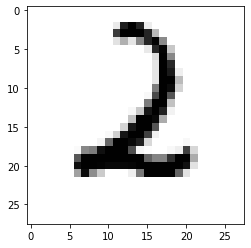

In [0]:
print_random_image(122,training_images)


**Function for taking gradients of the cost wrt the input image**

In [0]:

loss_object = tf.keras.losses.CategoricalCrossentropy()
def create_adversarial_pattern(input_image, ground_truth):
  input_image=tf.reshape(input_image,(1,28,28,1))
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = tf.convert_to_tensor(model(input_image))
   
    loss = loss_object(ground_truth,prediction)
       
  #Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss,input_image)
  
  #Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

**Helper Functions**

In [0]:
# returns the number from the prediction
def find_label(prediction):
  max=-1
  index=-1
  for i in range(10):
    if prediction[0,i]>max:
      max=prediction[0,i]
      index=i
  return index

def get_gradients(test_images,labels_test,model):
  gradients=[]
  for i in tqdm(range(test_images.shape[0])):
    image=test_images[i]
    image=tf.reshape(image,(1,28,28,1))
    label=tf.convert_to_tensor(labels_test[i,:])
    label=tf.reshape(label,(1,10))
    perturbation= create_adversarial_pattern(image,label)
    gradients.append(perturbation)
  return gradients


#finding the accuracy of the model on the adversarial examples of the test set and finding the misclassified examples
epsilons = [0, .05, .1, .15]
def model_accuracy_on_adversarial_examples(test_images,gradients,test_labels,epsilons,model):
  counts=[]
  misclassified_indices_list=[]
  misclassified_images_list=[]
  predictions_list=[]
  for i in range(len(epsilons)):
    count=0
    misclassified_indices=[]   #indices of the test examples which were earlier detected correctly but not after adding perturbation
    misclassified_images=[]    #test images which were earlier detected correctly but not after adding perturbation
    predictions=[]                    #predicted labels of the misclassified images
    eps=epsilons[i]
    for i in tqdm(range(10000)):
      image=test_images[i]
      image=tf.reshape(image,(1,28,28,1))
      adv_x=image+eps*gradients[i]
      pred=model(adv_x)
      adv_label=find_label(pred)
      original_label=find_label(model(image))
    
      if adv_label==test_labels[i]:
        count=count+1
      elif original_label==test_labels[i]:
        misclassified_indices.append(i)
        misclassified_images.append(adv_x)
        predictions.append(adv_label)
    counts.append(count)
    misclassified_indices_list.append(misclassified_indices)
    misclassified_images_list.append(misclassified_images)
    predictions_list.append(predictions)
    print("Test Accuracy for epsilon= {} : {}".format(eps,count/100))
  return misclassified_indices_list,misclassified_images_list,predictions_list,counts


**Calculating Gradients with respect to test images**

In [0]:
gradients= get_gradients(test_images,labels_test,model)

100%|██████████| 10000/10000 [02:01<00:00, 82.52it/s]


**Generating and Testing Adversarial Examples for different values of epsilon**

In [0]:

misclassified_indices_list,misclassified_images_list,predictions_list,counts = model_accuracy_on_adversarial_examples(test_images,gradients,test_labels,epsilons,model)

  0%|          | 6/10000 [00:00<03:03, 54.46it/s]

Test Accuracy for epsilon= 0 : 99.28


  0%|          | 6/10000 [00:00<02:56, 56.51it/s]

Test Accuracy for epsilon= 0.05 : 93.72


  0%|          | 6/10000 [00:00<03:02, 54.74it/s]

Test Accuracy for epsilon= 0.1 : 77.88


100%|██████████| 10000/10000 [03:14<00:00, 51.37it/s]

Test Accuracy for epsilon= 0.15 : 55.98


**Displaying misclassified images for different values of epsilon**

0


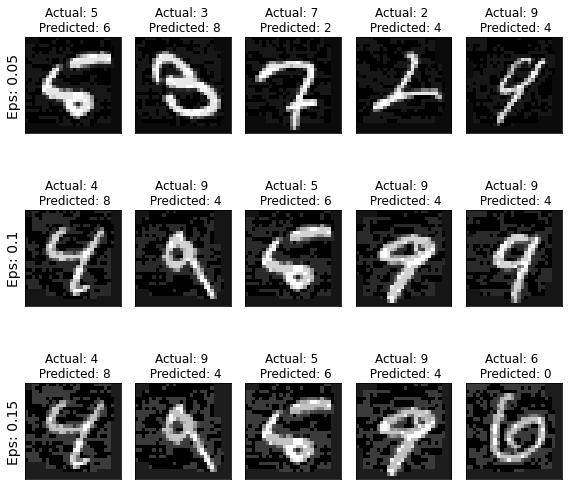

In [0]:

cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
  if i==0:
    print(0)
  else:
    for j in range(5):
      img = downsize(misclassified_images_list[i][j])
      cnt += 1
      plt.subplot(len(epsilons),5,cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      plt.title("Actual: {} \n Predicted: {}".format(test_labels[misclassified_indices_list[i][j]],predictions_list[i][j]) )
      plt.imshow(img, cmap="gray")
plt.tight_layout()
plt.show()


**New Training set is created with adversarial examples**

In [0]:

epsilons=[0.05,0.1,0.15]
def create_new_training_set(training_images,labels_training,epsilons,gradients_train):

  new_training_set_images_list=[]
  new_training_set_labels_list=[]
  for j in range(len(epsilons)):
    print("\n For epsilon = {}".format(epsilons[j]))
    new_training_images=tf.Variable(tf.zeros((120000,28,28,1),dtype=tf.float64))
    new_training_labels=tf.Variable(tf.zeros((120000,10),dtype=tf.float64))
    new_training_images=new_training_images[0:60000,:,:,:].assign(training_images)
    new_training_labels=new_training_labels[0:60000,:].assign(labels_training)
    new_training_labels=new_training_labels[60000:120000,:].assign(labels_training)
    for i in tqdm(range(60000)):
      image=training_images[i]
      image=tf.reshape(image,(1,28,28,1))
    
      adv_x=image+epsilons[j]*gradients_train[i]
      new_training_images=new_training_images[i+60000,:,:,:].assign(upsize(adv_x))
    new_training_set_images_list.append(new_training_images)
    new_training_set_labels_list.append(new_training_labels)
  return new_training_set_images_list,new_training_set_labels_list

In [0]:
gradients_train=get_gradients(training_images,labels_training,model)

100%|██████████| 60000/60000 [12:07<00:00, 82.49it/s]


In [0]:
new_training_set_images_list,new_training_set_labels_list = create_new_training_set(training_images,labels_training,epsilons,gradients_train)

  0%|          | 8/60000 [00:00<12:40, 78.92it/s]


 For epsilon = 0.05


  0%|          | 12/60000 [00:00<09:01, 110.86it/s]


 For epsilon = 0.1


  0%|          | 4/60000 [00:00<26:56, 37.10it/s]


 For epsilon = 0.15


100%|██████████| 60000/60000 [09:45<00:00, 102.49it/s]


**Training and Testing with new model**

In [0]:
# layers of model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()                               ### gives a table of all the layers in the CNN
print(new_training_set_images_list[1].shape)
print(new_training_set_labels_list[1])
print(training_images.shape)
print(labels_training.shape)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [0]:
#training                                                                                 
new_training_images=tf.convert_to_tensor(new_training_set_images_list[1])  #adversarial examples with epsilon=0.1 are added in the training set
new_training_labels=tf.convert_to_tensor(new_training_set_labels_list[1])
model.fit(new_training_images, new_training_labels, epochs=5)
#testing
test_loss,test_acc = model.evaluate(test_images, labels_test)
print("Test Accuracy=",test_acc*100,"%")

Epoch 1/5
3750/3750 [==============================] - 22s 6ms/step - loss: 0.1292 - accuracy: 0.9599
Epoch 2/5
3750/3750 [==============================] - 22s 6ms/step - loss: 0.0423 - accuracy: 0.9869
Epoch 3/5
3750/3750 [==============================] - 22s 6ms/step - loss: 0.0318 - accuracy: 0.9901
Epoch 4/5
3750/3750 [==============================] - 22s 6ms/step - loss: 0.0260 - accuracy: 0.9918
Epoch 5/5
313/313 [==============================] - 1s 4ms/step - loss: 0.0314 - accuracy: 0.9903
Test Accuracy= 99.02999997138977 %


**Testing Adversarial Examples for different values of epsilon on new model**

In [0]:
misclassified_indices_list1,misclassified_images_list1,predictions_list1,counts1 = model_accuracy_on_adversarial_examples(test_images,gradients,test_labels,epsilons,model)

  0%|          | 6/10000 [00:00<03:04, 54.09it/s]

Test Accuracy for epsilon= 0.05 : 99.65


  0%|          | 5/10000 [00:00<03:20, 49.77it/s]

Test Accuracy for epsilon= 0.1 : 99.77


100%|██████████| 10000/10000 [03:14<00:00, 51.42it/s]

Test Accuracy for epsilon= 0.15 : 99.7
